# Lab Seven: RNNs

#### Machine Learning in Python
    
Will Lacey - 45906124 - <strong>CSE7324</strong>
<br>
Roger Wong - 43867412 - <strong>CSE5324</strong>

## Preparation (30 points total)



Okay last lab! <strong>Whoop whoop!</strong> Let's start it off with some essential imports that we'll need for data analytics.

In [48]:
from copy import deepcopy
import keras_metrics as km
import keras
import keras.backend as K
from mlxtend.evaluate import mcnemar_table
from mlxtend.evaluate import mcnemar
from keras.preprocessing import sequence
from keras.layers import Embedding
from keras.models import Sequential
from keras.models import Input, Model
from keras.layers import Dense
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.layers import LSTM, GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib
from matplotlib import pyplot as plt

import numpy as np

import pandas as pd

import random

import seaborn as sns
sns.set(style='darkgrid')

import sklearn
from sklearn import metrics as mt
from sklearn.metrics import roc_curve, auc, recall_score

import sys

import warnings
warnings.simplefilter('ignore')

<em> 
    <strong> [10 points]</strong> Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed). Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). Discuss methods of tokenization in your dataset as well as any decisions to force a specific length of sequence.</em>
    

The dataset we are using for this lab is the <strong>SMS Spam Collection Dataset</strong>, which is a dataset that contains more than 5000 examples of texting data. Among this dataset are various text messages that are either classified as benign or malicious, or alternatively <strong>ham</strong> or <strong>spam</strong>. This next cell loads in the csv file.

In [2]:
try:
    df = pd.read_csv('spam.csv', encoding='latin-1')
    print("Succeeded to Open File.\n")
    df.info()
    
except IOError:
    print("Failed to Open Files. Quitting Program.")
    sys.exit

Succeeded to Open File.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
v1            5572 non-null object
v2            5572 non-null object
Unnamed: 2    50 non-null object
Unnamed: 3    12 non-null object
Unnamed: 4    6 non-null object
dtypes: object(5)
memory usage: 217.7+ KB


In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


The <strong>SMS Spam Collection Dataset</strong> contains 5 features, 3 of which are useless to our analysis. In the next cell we will both replace the classes <strong>ham</strong> and <strong>spam</strong> with a binary encoding and drop the unnecessary features.

In [4]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
df.v1.replace(to_replace=['ham','spam'], value=(0,1),inplace=True)
df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


Alrighty, now that we have a pandas dataframe with just our text messages and classifications, we are going to create a dataset object, <strong>SMS</strong>, that will allow us to perform useful operations on our data. This object will contain a tokenizer and a method for splitting and shuffling our data.

Here is a more detailed view of the datamembers.
    
    data - A set of padded numpy vectors in a tokenizer sequence format
    target - A binary transform of ham and spam classifications; ham: 0 & spam: 1
    tokenizer - A Tokenizer object fit on text data from the pandas dataframe

In [5]:
class SMS:
    def __init__(self, df):
        """Dataset constructor; Creates object with three datamembers:
        data, target, and tokenizer"""
        
        target = (df.v1).values
        text = (df.v2).values
        
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(text)
        data = tokenizer.texts_to_sequences(text)
        
        self.data = np.array(data)
        self.target = target
        self.tokenizer = tokenizer
            
    def load_data(self, test_split, shuffle=True):
        """Returns a split of the data and target; makes sure that 
        each class is split accordingly and shuffled if specified"""
        
        data_copy = deepcopy(self.data)
        target_copy = deepcopy(self.target)
        
        # Gather each class
        data_0 = data_copy[target_copy == 0]
        data_1 = data_copy[target_copy == 1] 
        
        # Split each class
        split_index = int(test_split * len(data_0))
        data_0_test = data_0[0:split_index]
        data_0_train = data_0[split_index:len(data_0)]
        split_index = int(test_split * len(data_1))
        data_1_test = data_1[0:split_index]
        data_1_train = data_1[split_index:len(data_1)]
        
        # Combine each class and recreate target classes
        X_test = np.concatenate((data_0_test, data_1_test), axis=None)
        X_train = np.concatenate((data_0_train, data_1_train), axis=None)
        y_test = np.concatenate((np.zeros(len(data_0_test), int), np.ones(len(data_1_test), int)), axis=None)
        y_train = np.concatenate((np.zeros(len(data_0_train), int), np.ones(len(data_1_train), int)), axis=None)
        
        # Shuffles data if specified
        if shuffle:
            seed = random.randint(0, 10000)
            random.seed(seed)
            random.shuffle(X_train)
            random.seed(seed)
            random.shuffle(X_test)
            random.seed(seed)
            random.shuffle(y_train)
            random.seed(seed)
            random.shuffle(y_test)
        
        return (X_train, y_train), (X_test, y_test)

We're almost there. Time to make our final alteration to our dataset. 

In [6]:
# Declare SMS Object
sms = SMS(df)

# Call load_data() from the SMS container; split data into training and testing
(X_train, y_train), (X_test, y_test) = sms.load_data(test_split=0.2)

# Truncate and pad input sequences to be the same length
max_message_length = 100
X_train = sequence.pad_sequences(X_train, maxlen=max_message_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_message_length)

After our pre-processing, we have transformed the <strong>SMS Spam Collection Dataset</strong> into <strong>X_train</strong>, <strong>X_test</strong>, <strong>y_train</strong>, and <strong>y_test</strong> numpy vectors. Our message data, <strong>X_train</strong> and <strong>X_test</strong>, was padded and truncated into a fixed size of 100 numerically encoded words. From here, each word can be mapped back to its original value through the tokenizer datamember inside of the SMS object. We did this so that our RNN's could better handle the various sizes of the input message data and understand the differences in each word. 

The two classes of the dataset are evenly stratified within the training and testing splits, which is in accordance to the specified split percentage. Through the previous pre-processing, we will now be able to properly train and analyze our data. 

<em> 
    <strong> [10 points] </strong> Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.
</em>

Let's visualize the distribution of the message data.

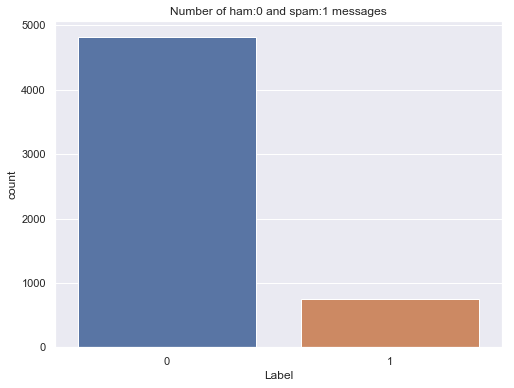

In [7]:
plt.figure(figsize=(8,6))
sns.countplot(df.v1)
plt.xlabel('Label')
plt.title('Number of ham:0 and spam:1 messages')
plt.show()

Because there is an unequal distribution of the classes, we will need to assign a class weight when training our recurrent neural networks.

In [8]:
print('weight metric calculation: ')
total = len(sms.target)
ham = len(sms.target[sms.target == 0]) # num of instances
spam = len(sms.target[sms.target == 1]) # num of instances

ham_weight = total / ham 
spam_weight = total / spam

print('0 - ham_weight: ', ham_weight)
print('1 - spam_weight: ', spam_weight)

class_weight = {
    0: ham_weight,
    1: spam_weight,
}

weight metric calculation: 
0 - ham_weight:  1.1548186528497408
1 - spam_weight:  7.459170013386881


Awesome. This class weight will be later used when we train. As you can see, through equal weighting, spam is 7 times more important to classify than ham. 

For the <strong>SMS Spam Collection Dataset</strong> we decided that correctly identifying spam was more important than ham. This is because in the real world, we want to identify if a message is harmful before we read it. If we fail to identify a malicious message, we could be at risk of jeopardizing our finacial well-being and security. In this vein, because a harmful message is identified as a positive, we implemented a <strong>recall</strong> scoring metric through the Keras metrics library. This way, we will prioritize learning what spam messages look like and lean towards a side of caution.

<em> 
    <strong>[10 points]</strong> Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 
</em>

In our dataset we have 5572 examples of text data, in which 747 messages are classified as spam. After reading a few messages on Kaggle, one quickly realizes the vocabulary of these spam messages is verbose. However, despite the verbosity, it's really not that difficult for a human to ascertain which messages are harmful and which are not.

Our dataset size places us on the threshold of whether or not we should use a Stratified cross fold or a stratified 80-20 split. Although, because malicious messages are so unique in format, size, and appearance, we believe that the 747 examples are sufficient, even after an 80-20 split, to aptly identify spam and train a neural network with a reasonable level of confidence in our success. Thus, we are using a stratified holdout, 80-20 split, to train our recurrent neural networks which will allow us to correspondingly measure how it will perform in a realistic environment.

## Modeling (60 points total)


The following method will be called to properly analize  how a neural network performed and converged over a series of training iterations. In addition, it will calculate the confusion matrix of its classes and the receiver operating characteristic for the network as well. The method will have an optional parameters to visualize this information.

In [27]:
def analyze_network(nn, history, X_test, y_test, plot=True):
    
    yhat_proba = nn.predict(X_test)
    yhat = np.round(yhat_proba)
    acc = mt.recall_score(y_test,yhat)
    confusion = mt.confusion_matrix(y_test,yhat)
    confusion_percentage = confusion/np.sum(confusion, axis=1)[:,np.newaxis]
    fpr, tpr, _ = roc_curve(y_test, yhat_proba)
    roc_auc = auc(fpr, tpr)
    
    if plot:
        plt.figure(figsize=(15,5))
        plt.subplots_adjust(left=0, right=1, wspace=0.3)

        # summarize history for accuracy
        plt.subplot(1,3,1)
        plt.plot(history.history['recall'])
        plt.plot(history.history['val_recall'])
        plt.title('model accuracy')
        plt.ylabel('recall')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')

        # summarize history for loss
        plt.subplot(1,3,2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')

        # summarize history for loss
        plt.subplot(1,3,3)
        sns.heatmap(confusion_percentage, annot=confusion_percentage, fmt='.2f', linewidths=2.5, cmap=['#304478', '#D67215'])
        plt.title('confusion: '+'{:.4f}'.format(acc))

        plt.show()
        
    return confusion, acc, fpr, tpr, roc_auc

<em> 
    <strong> [20 points] </strong>Investigate at least two different recurrent network architectures (perhaps LSTM and GRU). Be sure to use an embedding layer (pre-trained, from scratch, or both). Adjust hyper-parameters of the networks as needed to improve generalization performance. </em>


Before we begin investigating, we will declare some input parameters for building and training our models.

In [10]:
word_index = sms.tokenizer.word_index
EMBED_SIZE = 100
epochs = 10
batch_size = 16

The parameter we decided to hypertune was the embedding layer of the neural network. We decided to incorporate a GRU and a LSTM model with either an embedding layer that was built from scratch or pre-trained. Before constructing our models, let's create our two parameter, embedding layers.

Building an Embedding Layer from Scratch:

In [11]:
embedding_scratch = Embedding(len(word_index) + 1, # input dimension
                    EMBED_SIZE, # output dimension size
                    input_length=max_message_length)

Building an Embedding Layer that is Pre-trained:
<br>
<em>(The first cell takes a few seconds to parse the pre-trained weights)</em>

In [12]:
%%time

# the embed size should match the file you load glove from
embeddings_index = {}
f = open('glove/glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

CPU times: user 9.61 s, sys: 300 ms, total: 9.91 s
Wall time: 9.92 s


In [13]:
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [14]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

(8921, 100)


In [15]:
embedding_pre = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=max_message_length,
                            trainable=False)

Next, we build and train our four models. This will consist of the following:
<ul>
    <li><strong>GRU</strong>, Embedded Layer Built from <strong>Scratch</strong></li>
    <li><strong>GRU</strong>, Embedded Layer Built from <strong>Pre-trained</strong> glove file</li>
    <li><strong>LSTM</strong>, Embedded Layer Built from <strong>Scratch</strong></li>
    <li><strong>LSTM</strong>, Embedded Layer Built from <strong>Pre-trained</strong> glove file</li>
</ul>

### First GRU Model: From Scratch Embedding

In [16]:
gru_scratch = Sequential()
gru_scratch.add(embedding_scratch)
gru_scratch.add(GRU(max_message_length,dropout=0.2, recurrent_dropout=0.2))
gru_scratch.add(Dense(1, activation='sigmoid'))
gru_scratch.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=[km.binary_recall()]) 

gru_scratch.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          892100    
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               60300     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 952,501
Trainable params: 952,501
Non-trainable params: 0
_________________________________________________________________


In [17]:
%%time

history_gru_scratch = gru_scratch.fit(X_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, validation_data=(X_test, y_test))

Train on 4458 samples, validate on 1114 samples
Epoch 1/10
4458/4458 [==============================] - 27s 6ms/step - loss: 0.4718 - recall: 0.8779 - val_loss: 0.1011 - val_recall: 0.9664
Epoch 2/10
4458/4458 [==============================] - 27s 6ms/step - loss: 0.1541 - recall: 0.9632 - val_loss: 0.0800 - val_recall: 0.9732
Epoch 3/10
4458/4458 [==============================] - 27s 6ms/step - loss: 0.1219 - recall: 0.9716 - val_loss: 0.0655 - val_recall: 0.9732
Epoch 4/10
4458/4458 [==============================] - 28s 6ms/step - loss: 0.0856 - recall: 0.9783 - val_loss: 0.0927 - val_recall: 0.9799
Epoch 5/10
4458/4458 [==============================] - 28s 6ms/step - loss: 0.0764 - recall: 0.9833 - val_loss: 0.1002 - val_recall: 0.9799
Epoch 6/10
4458/4458 [==============================] - 28s 6ms/step - loss: 0.0559 - recall: 0.9849 - val_loss: 0.0693 - val_recall: 0.9799
Epoch 7/10
4458/4458 [==============================] - 28s 6ms/step - loss: 0.0492 - recall: 0.9933 - val

### Second GRU Model: Pre-trained Embedding

In [18]:
gru_pre = Sequential()
gru_pre.add(embedding_pre)
gru_pre.add(GRU(max_message_length,dropout=0.2, recurrent_dropout=0.2))
gru_pre.add(Dense(1, activation='sigmoid'))
gru_pre.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=[km.binary_recall()])

gru_pre.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          892100    
_________________________________________________________________
gru_2 (GRU)                  (None, 100)               60300     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 952,501
Trainable params: 60,401
Non-trainable params: 892,100
_________________________________________________________________


In [19]:
%%time

history_gru_pre = gru_pre.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, class_weight=class_weight, batch_size=batch_size)

Train on 4458 samples, validate on 1114 samples
Epoch 1/10
4458/4458 [==============================] - 26s 6ms/step - loss: 0.5439 - recall: 0.8729 - val_loss: 0.1885 - val_recall: 0.9866
Epoch 2/10
4458/4458 [==============================] - 25s 6ms/step - loss: 0.3136 - recall: 0.9314 - val_loss: 0.0837 - val_recall: 0.9799
Epoch 3/10
4458/4458 [==============================] - 24s 5ms/step - loss: 0.2375 - recall: 0.9548 - val_loss: 0.0511 - val_recall: 0.9732
Epoch 4/10
4458/4458 [==============================] - 24s 5ms/step - loss: 0.2126 - recall: 0.9565 - val_loss: 0.0399 - val_recall: 0.9664
Epoch 5/10
4458/4458 [==============================] - 24s 5ms/step - loss: 0.1696 - recall: 0.9548 - val_loss: 0.0422 - val_recall: 0.9732
Epoch 6/10
4458/4458 [==============================] - 25s 6ms/step - loss: 0.1349 - recall: 0.9732 - val_loss: 0.0427 - val_recall: 0.9732
Epoch 7/10
4458/4458 [==============================] - 24s 5ms/step - loss: 0.1299 - recall: 0.9732 - val

### First LSTM Model: From Scratch Embedding

In [20]:
lstm_scratch = Sequential()
lstm_scratch.add(embedding_scratch)
lstm_scratch.add(LSTM(max_message_length,dropout=0.2, recurrent_dropout=0.2))
lstm_scratch.add(Dense(1, activation='sigmoid'))
lstm_scratch.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=[km.binary_recall()])

lstm_scratch.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          892100    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 972,601
Trainable params: 972,601
Non-trainable params: 0
_________________________________________________________________


In [21]:
%%time

history_lstm_scratch = lstm_scratch.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, class_weight=class_weight, batch_size=batch_size)

Train on 4458 samples, validate on 1114 samples
Epoch 1/10
4458/4458 [==============================] - 36s 8ms/step - loss: 0.1535 - recall: 0.9515 - val_loss: 0.0615 - val_recall: 0.9732
Epoch 2/10
4458/4458 [==============================] - 35s 8ms/step - loss: 0.0634 - recall: 0.9816 - val_loss: 0.1081 - val_recall: 0.9866
Epoch 3/10
4458/4458 [==============================] - 34s 8ms/step - loss: 0.0435 - recall: 0.9900 - val_loss: 0.1006 - val_recall: 0.9866
Epoch 4/10
4458/4458 [==============================] - 34s 8ms/step - loss: 0.0466 - recall: 0.9916 - val_loss: 0.0973 - val_recall: 0.9866
Epoch 5/10
4458/4458 [==============================] - 34s 8ms/step - loss: 0.0332 - recall: 0.9900 - val_loss: 0.0521 - val_recall: 0.9799
Epoch 6/10
4458/4458 [==============================] - 34s 8ms/step - loss: 0.0489 - recall: 0.9916 - val_loss: 0.0924 - val_recall: 0.9799
Epoch 7/10
4458/4458 [==============================] - 34s 8ms/step - loss: 0.0236 - recall: 0.9916 - val

### Second LSTM Model: Pre-trained Embedding

In [22]:
lstm_pre = Sequential()
lstm_pre.add(embedding_pre)
lstm_pre.add(LSTM(max_message_length,dropout=0.2, recurrent_dropout=0.2))
lstm_pre.add(Dense(1, activation='sigmoid'))
lstm_pre.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=[km.binary_recall()])

lstm_pre.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          892100    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 972,601
Trainable params: 80,501
Non-trainable params: 892,100
_________________________________________________________________


In [23]:
%%time

history_lstm_pre = lstm_pre.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, class_weight=class_weight, batch_size=batch_size)

Train on 4458 samples, validate on 1114 samples
Epoch 1/10
4458/4458 [==============================] - 30s 7ms/step - loss: 0.4689 - recall: 0.8913 - val_loss: 0.1109 - val_recall: 0.9530
Epoch 2/10
4458/4458 [==============================] - 30s 7ms/step - loss: 0.3200 - recall: 0.9231 - val_loss: 0.1139 - val_recall: 0.9732
Epoch 3/10
4458/4458 [==============================] - 30s 7ms/step - loss: 0.2749 - recall: 0.9381 - val_loss: 0.0623 - val_recall: 0.9396
Epoch 4/10
4458/4458 [==============================] - 30s 7ms/step - loss: 0.2320 - recall: 0.9415 - val_loss: 0.0823 - val_recall: 0.9597
Epoch 5/10
4458/4458 [==============================] - 30s 7ms/step - loss: 0.2075 - recall: 0.9532 - val_loss: 0.0769 - val_recall: 0.9530
Epoch 6/10
4458/4458 [==============================] - 30s 7ms/step - loss: 0.1738 - recall: 0.9599 - val_loss: 0.0868 - val_recall: 0.9732
Epoch 7/10
4458/4458 [==============================] - 30s 7ms/step - loss: 0.1813 - recall: 0.9565 - val

<em> 
    <strong>[20 points]</strong> Using the best RNN parameters and architecture, add a second recurrent chain to your RNN. The input to the second chain should be the output sequence of the first chain. Visualize the performance of training and validation sets versus the training iterations. 
</em>

In [24]:
def stat_comparison(model1,model2, print_results):
    y_model1 = np.round(model1.predict(X_test)).flatten()
    y_model2 = np.round(model2.predict(X_test)).flatten()
    tb = mcnemar_table(y_target=y_test, 
                       y_model1=y_model1, 
                       y_model2=y_model2)
    chi2, p = mcnemar(ary=tb, corrected=True)
    if print_results == True:
        print('chi-squared:', chi2)
        print('p-value:', p)
        print('')

In [25]:
print('Comparison between Pre-Trained Embedding GRU and From Scratch Embedding GRU: ')
stat_comparison(gru_pre, gru_scratch, True)

print('Comparison between Pre-Trained Embedding GRU and From From Scratch Embedding LSTM: ')
stat_comparison(gru_pre, lstm_scratch, True)

print('Comparison between Pre-Trained Embedding GRU and Pre-Trained Embedding LSTM: ')
stat_comparison(gru_pre, lstm_pre, True)

print('Comparison between From Scratch Embedding GRU and From Scratch Embedding LSTM: ')
stat_comparison(gru_scratch, lstm_scratch, True)

print('Comparison between From Scratch Embedding GRU and Pre-Trained Embedding LSTM: ')
stat_comparison(gru_scratch, lstm_pre, True)

print('Comparison between From Scratch Embedding LSTM and Pre-Trained Embedding LSTM: ')
stat_comparison(lstm_scratch, lstm_pre, True)

Comparison between Pre-Trained Embedding GRU and From Scratch Embedding GRU: 
chi-squared: 5.818181818181818
p-value: 0.015861332739773026

Comparison between Pre-Trained Embedding GRU and From From Scratch Embedding LSTM: 
chi-squared: 24.735294117647058
p-value: 6.576869920648128e-07

Comparison between Pre-Trained Embedding GRU and Pre-Trained Embedding LSTM: 
chi-squared: 9.090909090909092
p-value: 0.0025688315270227116

Comparison between From Scratch Embedding GRU and From Scratch Embedding LSTM: 
chi-squared: 17.391304347826086
p-value: 3.0421456547338772e-05

Comparison between From Scratch Embedding GRU and Pre-Trained Embedding LSTM: 
chi-squared: 0.05
p-value: 0.8230632737581214

Comparison between From Scratch Embedding LSTM and Pre-Trained Embedding LSTM: 
chi-squared: 7.902439024390244
p-value: 0.004936818556325073



For our statistical comparison test, we will be using the McNemar Test. We will be using the p-value calculated from the test and compare it to our significance level of α=0.05.

As you can see above, there isn't any significant difference between:
<ul>
    <li>Pre-Trained Embedding GRU and From From Scratch Embedding LSTM</li>
    <li>Scratch Embedding GRU and Pre-Trained Embedding LSTM</li>
    <li>From Scratch Embedding GRU and From Scratch Embedding LSTM</li>
</ul>
    
Since the p-value is larger than our assumed significance threshold, we cannot reject our null hypothesis and assume that there is no significant difference between the two predictive models.

But the models: 
<ul>
    <li>Pre-Trained Embedding GRU and From Scratch Embedding GRU</li>
    <li>Pre-Trained Embedding GRU and Pre-Trained Embedding LSTM</li>
    <li>From Scratch Embedding LSTM and Pre-Trained Embedding LSTM</li>
</ul>
have a p-values lower than our significance threshold. So in conclusion, these models are the only ones significantly different from one another  

From viewing the analytics and recall visualizations in the next cell, we can conclude the following:
<ul>
    <li>The <strong>Scratch Embedding GRU</strong> is a better model than the Pre-Trained Embedding</li>
    <li>The <strong>Pre-Trained Embedding GRU</strong> is a better model than the Pre-Trained Embedding LSTM</li>
    <li>The <strong>Scratch Embedding LSTM</strong> is a better model than the Pre-Trained Embedding LSTM</li>
</ul>
And thus, because the Scatch Embedding Models are better than the Pre-Trained Models, and because the Scratch Embedding LSTM and GRU are not statistically different, we can conclude that <strong>both</strong> the <strong>Scratch Embedding GRU</strong> and <strong>Scratch Embedding LSTM</strong> are the <strong>best</strong> models.

Because we have two models that are statistically equivalent, we decided to neglect the GRU and go ahead and focus on the Scratch Embedding LSTM to append a second recurrent layer too.

In [33]:
chain = Sequential()
chain.add(embedding_scratch)
chain.add(LSTM(max_message_length,dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
chain.add(LSTM(max_message_length,dropout=0.4, recurrent_dropout=0.4))
chain.add(Dense(1, activation='sigmoid'))
chain.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=[km.binary_recall()])

chain.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          892100    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 100)          80400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 1,053,001
Trainable params: 1,053,001
Non-trainable params: 0
_________________________________________________________________


In [34]:
%%time

history = chain.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, class_weight=class_weight, batch_size=batch_size)

Train on 4458 samples, validate on 1114 samples
Epoch 1/10
4458/4458 [==============================] - 66s 15ms/step - loss: 0.1777 - recall: 0.9482 - val_loss: 0.0453 - val_recall: 0.9799
Epoch 2/10
4458/4458 [==============================] - 63s 14ms/step - loss: 0.0453 - recall: 0.9883 - val_loss: 0.0743 - val_recall: 0.9866
Epoch 3/10
4458/4458 [==============================] - 62s 14ms/step - loss: 0.0685 - recall: 0.9900 - val_loss: 0.0661 - val_recall: 0.9866
Epoch 4/10
4458/4458 [==============================] - 63s 14ms/step - loss: 0.0515 - recall: 0.9883 - val_loss: 0.0940 - val_recall: 0.9866
Epoch 5/10
4458/4458 [==============================] - 63s 14ms/step - loss: 0.0462 - recall: 0.9900 - val_loss: 0.1165 - val_recall: 0.9866
Epoch 6/10
4458/4458 [==============================] - 63s 14ms/step - loss: 0.0492 - recall: 0.9933 - val_loss: 0.1078 - val_recall: 0.9866
Epoch 7/10
4458/4458 [==============================] - 64s 14ms/step - loss: 0.0361 - recall: 0.993

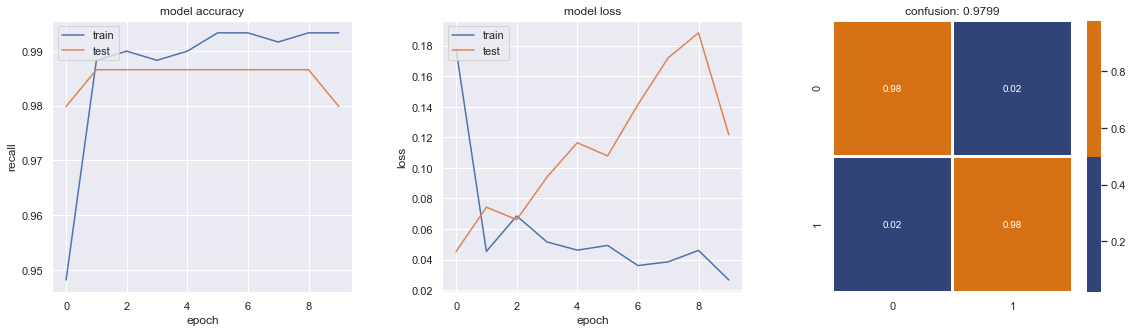

In [35]:
# Chained LSTM : Scratch Embedding

confusion_chain, acc_chain, fpr_chain, tpr_chain, roc_auc_chain = analyze_network(chain, 
                                                                                  history, 
                                                                                  X_test, 
                                                                                  y_test
)

<em> 
    <strong> [20 points]</strong> Use the method of cross validation and evaluation criteria that you argued for at the beginning of the lab. Visualize the results of all the RNNs you trained.  Use proper statistical comparison techniques to determine which method(s) is (are) superior.  </em>

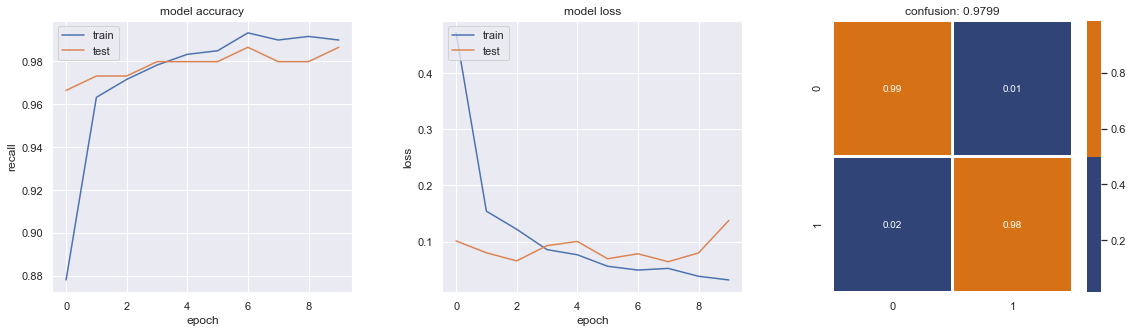

In [28]:
# 1st GRU : Scratch Embedding

confusion_gru_scratch, acc_gru_scratch, fpr_gru_scratch, tpr_gru_scratch, roc_auc_gru_scratch = analyze_network(gru_scratch, 
                                                                                                                history_gru_scratch, 
                                                                                                                X_test, 
                                                                                                                y_test
)

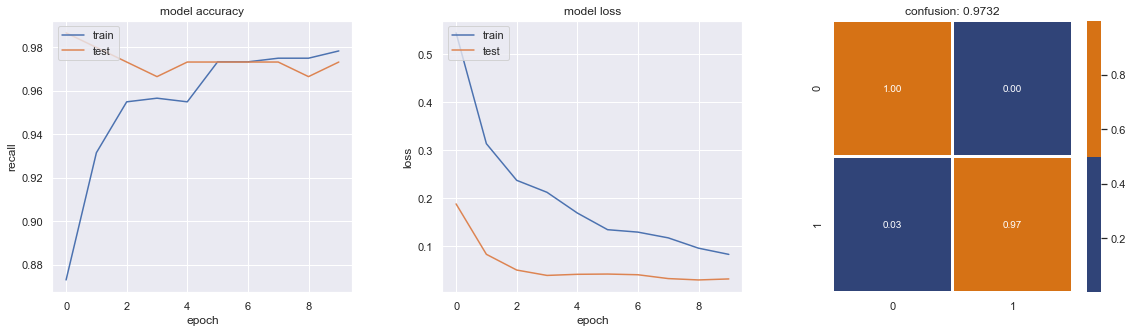

In [29]:
# 2nd GRU : Pre-trained Embedding

confusion_gru_pre, acc_gru_pre, fpr_gru_pre, tpr_gru_pre, roc_auc_gru_pre = analyze_network(gru_pre, 
                                                                                            history_gru_pre,
                                                                                            X_test, 
                                                                                            y_test
)

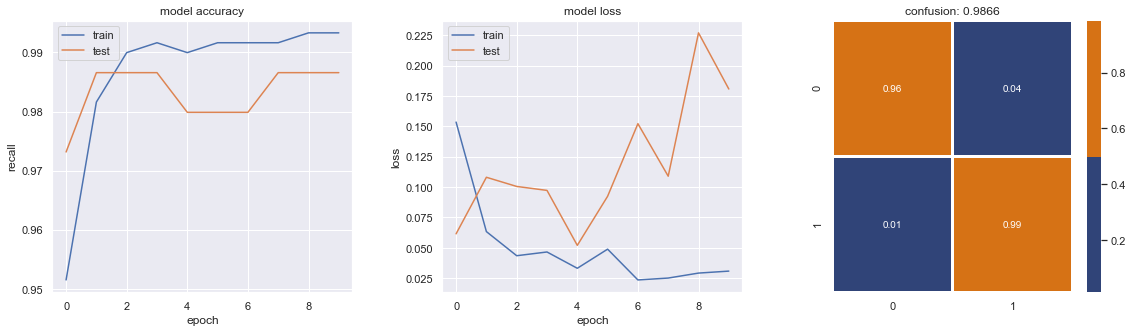

In [30]:
# 1st LSTM : Scratch Embedding

confusion_lstm_scratch, acc_lstm_scratch, fpr_lstm_scratch, tpr_lstm_scratch, roc_auc_lstm_scratch = analyze_network(lstm_scratch, 
                                                                                                                     history_lstm_scratch, 
                                                                                                                     X_test, 
                                                                                                                     y_test
)

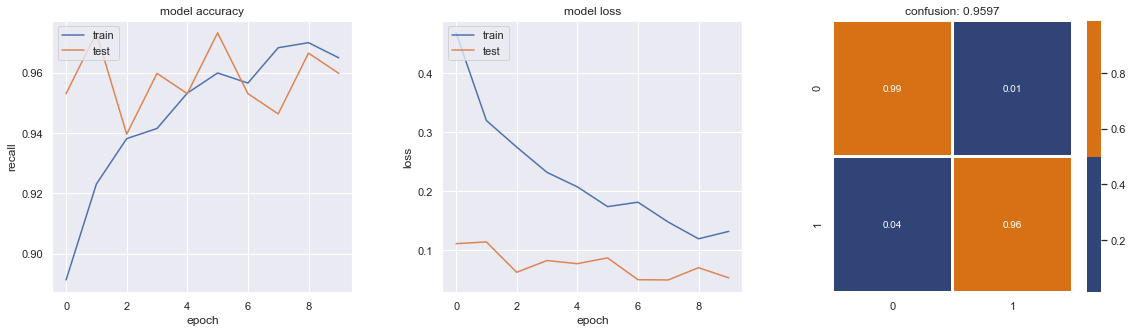

In [37]:
# 2nd LSTM : Pre-trained Embedding

confusion_lstm_pre, acc_lstm_pre, fpr_lstm_pre, tpr_lstm_pre, roc_auc_lstm_pre = analyze_network(lstm_pre, 
                                                                                                 history_lstm_pre, 
                                                                                                 X_test, 
                                                                                                 y_test
)

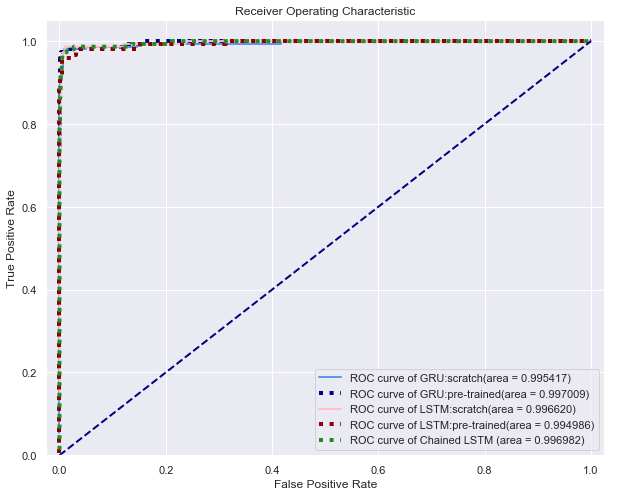

In [47]:
plt.figure(figsize=(10,8))
lw = 2

# GRU_SCRATCH
plt.plot(fpr_gru_scratch, tpr_gru_scratch, color='cornflowerblue',
         lw=lw, label='ROC curve of GRU:scratch(area = %0.6f)' % roc_auc_gru_scratch)

# GRU_PRE-TRAINED
plt.plot(fpr_gru_pre, tpr_gru_pre, color='navy', linestyle=':', linewidth=4,
         lw=lw, label='ROC curve of GRU:pre-trained(area = %0.6f)' % roc_auc_gru_pre)

# LSTM_SCRATCH
plt.plot(fpr_lstm_scratch, tpr_lstm_scratch, color='pink',
         lw=lw, label='ROC curve of LSTM:scratch(area = %0.6f)' % roc_auc_lstm_scratch)

# LSTM_PRE-TRAINED
plt.plot(fpr_lstm_pre, tpr_lstm_pre, color='darkred', linestyle=':', linewidth=4,
         lw=lw, label='ROC curve of LSTM:pre-trained(area = %0.6f)' % roc_auc_lstm_pre)

# CHAINED LSTM
plt.plot(fpr_chain, tpr_chain, color='forestgreen', linestyle=':', linewidth=4,
         lw=lw, label='ROC curve of Chained LSTM (area = %0.6f)' % roc_auc_chain)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.025, 1.025])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Unfortunately, the receiver operating characteristic doesn't yield much information. Even the area under the curve is misleading to which the best models are. If we were to infer which model is greatest, we'd have to look back to our statistical tests. Nonetheless, it still shows that all models yield a high accuracy.

### Some Takeaways

While we can be 95% confident that <strong>both</strong> the <strong>Scratch Embedding GRU</strong> and <strong>Scratch Embedding LSTM</strong> are the <strong>best</strong> models, we have to admit that the pre-trained models were at a disadvantage to the scratch embedding models. In building the pre-trained embeddings, we set the layer to be untrainable. While this is generally a good idea when the RNN begins to train and its initialized weights are junk, it becomes detrimental after a it gains accuracy and starts to build a proper weight matrix. In the future, if we were to have more time and be able to retrain, we would train the pre-trained models for a few epochs, then retrain with an embedding layer that is trainable.

## Exceptional Work (10 points total)
<em>
    <strong>[10 points]</strong> Use t-SNE (or SVD) to visualize the word embeddings of a subset of words in your vocabulary. Try to interpret what each dimension reflects (in your own words). That is, try to explain what aspect of the language is encoded in the reduced dimensionality embedding. 
</em>

<em>
     Another Idea (NOT required): Try to create a RNN for generating novel text. 
</em>

<strong>We have signed up for the biometrics volunteer study with Elena Sharp.</strong> We have signed up at separate times, a couple weeks in the future.

    Roger - Tuesday, May 21st @ 10:00 am
    Will  - Monday, May 27th @ 10:00 am